# Hello

In [26]:
!pip install --upgrade sklearn-compat

  Attempting uninstall: sklearn-compat
    Found existing installation: sklearn-compat 0.1.3
    Uninstalling sklearn-compat-0.1.3:
      Successfully uninstalled sklearn-compat-0.1.3


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GroupKFold, cross_val_predict
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
# from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
import warnings
warnings.filterwarnings('ignore')

# Set display options
pd.set_option('display.max_columns', 60)
plt.style.use('seaborn-v0_8-whitegrid')


A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.4.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\knich\miniconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\knich\miniconda3\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\knich\miniconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start()
  File "C:\Users\knich\miniconda3\Lib\site-

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.4.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.




A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.4.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\knich\miniconda3\Lib\site-packages\ipykernel_launcher.py", line 17, in <module>
    app.launch_new_instance()
  File "C:\Users\knich\miniconda3\Lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\knich\miniconda3\Lib\site-packages\ipykernel\kernelapp.py", line 701, in start
    self.io_loop.start()
  File "C:\Users\knich\miniconda3\Lib\site-

ImportError: 
A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.4.2 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.



In [2]:
train = pd.read_csv('data/training_ALL.csv')

In [3]:
submit = pd.read_csv('data/testing_ALL.csv')

In [4]:
print(f"Training shape: {train.shape}")
print(f"Submission shape: {submit.shape}")
print(f"\nTraining columns:\n{list(train.columns)}")
print(f"\nSubmission columns:\n{list(submit.columns)}")

Training shape: (9319, 55)
Submission shape: (200, 55)

Training columns:
['Latitude', 'Longitude', 'Sample Date', 'Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus', 'pet', '_merge_terra', 'nir', 'green', 'swir16', 'swir22', 'NDMI', 'MNDWI', '_merge_landsat', 'Impute_Method', 'geometry', 'STAT_ID', 'sc', 'ss', 'su', 'mt', 'va', 'vb', 'vi', 'pa', 'pb', 'pi', 'GLC_Artificial', 'GLC_Managed', 'GLC_Water', 'GLC_Aquatic_Veg', 'GLC_PERC_COV', 'Popdens_00', 'Soil_pH', 'SOC', 'Soil_wetness', 'dist_m', 'dist_km', 'Latitude_glorich', 'Longitude_glorich', 'date', 'Alkalinity', 'Cl', 'DIP', 'SO4', 'SpecCond25C', 'pH', 'Alkalinity_reliability', 'Cl_reliability', 'DIP_reliability', 'SO4_reliability', 'SpecCond25C_reliability', 'pH_reliability', 'date_diff_days']

Submission columns:
['Latitude', 'Longitude', 'Sample Date', 'Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus', 'pet', '_merge_terra', 'nir', 'green', 'swir16', 'swir22', 'NDMI', 'MNDW

In [5]:
# Target variables
TARGETS = ['Total Alkalinity', 'Electrical Conductance', 'Dissolved Reactive Phosphorus']

# Key columns (not features)
KEYS = ['Latitude', 'Longitude', 'Sample Date']

# Columns to DROP (metadata, merge indicators, redundant)
DROP_COLS = [
    '_merge_terra',      # Merge indicator
    '_merge_landsat',    # Merge indicator
    'Impute_Method',     # Metadata
    'geometry',          # Geometry object (can't use directly)
    'STAT_ID',           # Station ID (use for grouping, not as feature)
    'date',              # GLORICH date (redundant with Sample Date)
    'Latitude_glorich',  # Redundant lat
    'Longitude_glorich', # Redundant lon
]

# GLORICH features (historical water quality from nearby stations)
GLORICH_FEATURES = [
    'Alkalinity', 'Cl', 'DIP', 'SO4', 'SpecCond25C', 'pH',
    'Alkalinity_reliability', 'Cl_reliability', 'DIP_reliability',
    'SO4_reliability', 'SpecCond25C_reliability', 'pH_reliability',
    'date_diff_days', 'dist_m', 'dist_km'
]

# Lithology features (rock types from GLiM)
LITHOLOGY_FEATURES = ['sc', 'ss', 'su', 'mt', 'va', 'vb', 'vi', 'pa', 'pb', 'pi']

# Land cover features
LANDCOVER_FEATURES = ['GLC_Artificial', 'GLC_Managed', 'GLC_Water', 'GLC_Aquatic_Veg', 'GLC_PERC_COV']

# Remote sensing features
RS_FEATURES = ['pet', 'nir', 'green', 'swir16', 'swir22', 'NDMI', 'MNDWI']

# Soil & population features
SOIL_POP_FEATURES = ['Popdens_00', 'Soil_pH', 'SOC', 'Soil_wetness']

# Combine all feature groups
ALL_FEATURE_GROUPS = {
    'GLORICH': GLORICH_FEATURES,
    'Lithology': LITHOLOGY_FEATURES,
    'Land Cover': LANDCOVER_FEATURES,
    'Remote Sensing': RS_FEATURES,
    'Soil & Population': SOIL_POP_FEATURES
}

print("Feature groups defined:")
for group, features in ALL_FEATURE_GROUPS.items():
    print(f"  {group}: {len(features)} features")

Feature groups defined:
  GLORICH: 15 features
  Lithology: 10 features
  Land Cover: 5 features
  Remote Sensing: 7 features
  Soil & Population: 4 features


In [6]:
def preprocess(df, is_train=True):
    """Clean and preprocess dataframe"""
    df = df.copy()
    
    # Convert date
    df['Sample Date'] = pd.to_datetime(df['Sample Date'])
    
    # =========================================================================
    # TIME FEATURES
    # =========================================================================
    df['month'] = df['Sample Date'].dt.month
    df['day_of_year'] = df['Sample Date'].dt.dayofyear
    df['year'] = df['Sample Date'].dt.year
    df['quarter'] = df['Sample Date'].dt.quarter
    
    # Cyclic encoding
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['doy_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
    df['doy_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)
    
    # Season (South Africa: Oct-Mar = wet/summer)
    df['is_wet_season'] = df['month'].isin([10, 11, 12, 1, 2, 3]).astype(int)
    
    # =========================================================================
    # SPECTRAL RATIOS (if Landsat available)
    # =========================================================================
    if 'nir' in df.columns and 'green' in df.columns:
        df['nir_green_ratio'] = np.where(df['green'] > 0, df['nir'] / df['green'], np.nan)
        df['swir16_nir_ratio'] = np.where(df['nir'] > 0, df['swir16'] / df['nir'], np.nan)
        df['swir22_nir_ratio'] = np.where(df['nir'] > 0, df['swir22'] / df['nir'], np.nan)
        df['swir_ratio'] = np.where(df['swir22'] > 0, df['swir16'] / df['swir22'], np.nan)
        df['nir_minus_green'] = df['nir'] - df['green']
        df['swir_diff'] = df['swir16'] - df['swir22']
    
    # =========================================================================
    # SPATIAL FEATURES
    # =========================================================================
    df['lat_lon_interaction'] = df['Latitude'] * df['Longitude']
    df['dist_from_center'] = np.sqrt((df['Latitude'] + 29)**2 + (df['Longitude'] - 25)**2)
    
    # =========================================================================
    # GLORICH RELIABILITY-WEIGHTED FEATURES
    # =========================================================================
    # Weight GLORICH values by their reliability
    if 'Alkalinity' in df.columns and 'Alkalinity_reliability' in df.columns:
        df['Alkalinity_weighted'] = df['Alkalinity'] * df['Alkalinity_reliability']
        df['SpecCond_weighted'] = df['SpecCond25C'] * df['SpecCond25C_reliability']
        df['DIP_weighted'] = df['DIP'] * df['DIP_reliability']
        df['pH_weighted'] = df['pH'] * df['pH_reliability']
    
    # =========================================================================
    # INTERACTION FEATURES
    # =========================================================================
    # Lithology-Landcover interactions (geology affects runoff)
    if 'GLC_Artificial' in df.columns:
        # Total lithology diversity
        lith_cols = [c for c in LITHOLOGY_FEATURES if c in df.columns]
        df['lithology_diversity'] = (df[lith_cols] > 0).sum(axis=1)
        
        # Artificial land with carbonate rock
        df['artificial_carbonate'] = df['GLC_Artificial'] * df.get('sc', 0)
        
        # Agricultural pressure proxy
        df['managed_pop_pressure'] = df['GLC_Managed'] * np.log1p(df.get('Popdens_00', 0))
    
    # =========================================================================
    # DROP UNWANTED COLUMNS
    # =========================================================================
    cols_to_drop = [c for c in DROP_COLS if c in df.columns]
    df = df.drop(columns=cols_to_drop, errors='ignore')
    
    return df

In [7]:
train_processed = preprocess(train, is_train=True)
submit_processed = preprocess(submit, is_train=False)

print(f"Training after preprocessing: {train_processed.shape}")
print(f"Submission after preprocessing: {submit_processed.shape}")

Training after preprocessing: (9319, 71)
Submission after preprocessing: (200, 71)


In [8]:
# Get feature columns (everything except targets and keys)
feature_cols = [c for c in train_processed.columns 
                if c not in TARGETS + KEYS + ['Sample Date']]

print(f"Total features: {len(feature_cols)}")
print(f"\nFeature columns:\n{feature_cols}")

Total features: 65

Feature columns:
['pet', 'nir', 'green', 'swir16', 'swir22', 'NDMI', 'MNDWI', 'sc', 'ss', 'su', 'mt', 'va', 'vb', 'vi', 'pa', 'pb', 'pi', 'GLC_Artificial', 'GLC_Managed', 'GLC_Water', 'GLC_Aquatic_Veg', 'GLC_PERC_COV', 'Popdens_00', 'Soil_pH', 'SOC', 'Soil_wetness', 'dist_m', 'dist_km', 'Alkalinity', 'Cl', 'DIP', 'SO4', 'SpecCond25C', 'pH', 'Alkalinity_reliability', 'Cl_reliability', 'DIP_reliability', 'SO4_reliability', 'SpecCond25C_reliability', 'pH_reliability', 'date_diff_days', 'month', 'day_of_year', 'year', 'quarter', 'month_sin', 'month_cos', 'doy_sin', 'doy_cos', 'is_wet_season', 'nir_green_ratio', 'swir16_nir_ratio', 'swir22_nir_ratio', 'swir_ratio', 'nir_minus_green', 'swir_diff', 'lat_lon_interaction', 'dist_from_center', 'Alkalinity_weighted', 'SpecCond_weighted', 'DIP_weighted', 'pH_weighted', 'lithology_diversity', 'artificial_carbonate', 'managed_pop_pressure']


In [9]:
# Prepare X and y
X_train = train_processed[feature_cols].copy()
y_train = train_processed[TARGETS].copy()

# Check if submission has all features
missing_in_submit = [c for c in feature_cols if c not in submit_processed.columns]
if missing_in_submit:
    print(f"⚠️ Missing in submission: {missing_in_submit}")
    # Add missing columns with NaN
    for col in missing_in_submit:
        submit_processed[col] = np.nan

X_submit = submit_processed[feature_cols].copy()
# note: need to add submission preprocessing
print(f"\nX_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")


X_train shape: (9319, 65)
y_train shape: (9319, 3)


In [10]:
print("\n--- Missing Values in Training Features ---")
missing = X_train.isnull().sum()
missing_pct = (missing / len(X_train) * 100).round(1)
missing_df = pd.DataFrame({'count': missing, 'pct': missing_pct})
print(missing_df[missing_df['count'] > 0].sort_values('pct', ascending=False))

# %%
# Fill missing values with median (robust to outliers)
train_medians = X_train.median()
X_train_filled = X_train.fillna(train_medians)
X_submit_filled = X_submit.fillna(train_medians)

print(f"\n✓ Missing values filled with training medians")
print(f"  Remaining NaN in X_train: {X_train_filled.isnull().sum().sum()}")
print(f"  Remaining NaN in X_submit: {X_submit_filled.isnull().sum().sum()}")


--- Missing Values in Training Features ---
                         count   pct
Alkalinity                 987  10.6
Cl                         987  10.6
DIP                        987  10.6
SO4                        987  10.6
SpecCond25C                987  10.6
Alkalinity_reliability     987  10.6
Cl_reliability             987  10.6
DIP_reliability            987  10.6
SO4_reliability            987  10.6
DIP_weighted               987  10.6
SpecCond25C_reliability    987  10.6
SpecCond_weighted          987  10.6
Alkalinity_weighted        987  10.6
pH                         923   9.9
pH_reliability             923   9.9
date_diff_days             923   9.9
pH_weighted                923   9.9

✓ Missing values filled with training medians
  Remaining NaN in X_train: 0
  Remaining NaN in X_submit: 0


In [11]:
# Create spatial clusters for GroupKFold CV
# This prevents geographic leakage (nearby stations shouldn't be in same fold)

coords = train_processed[['Latitude', 'Longitude']].values
n_clusters = 15  # More clusters = stricter spatial separation

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
spatial_clusters = kmeans.fit_predict(coords)

print(f"Spatial clusters created: {n_clusters} clusters")
print(f"Cluster distribution:\n{pd.Series(spatial_clusters).value_counts().sort_index()}")

Spatial clusters created: 15 clusters
Cluster distribution:
0      802
1      457
2     1044
3      615
4      695
5      383
6     1032
7     1554
8      153
9      428
10     447
11     496
12     434
13     509
14     270
Name: count, dtype: int64


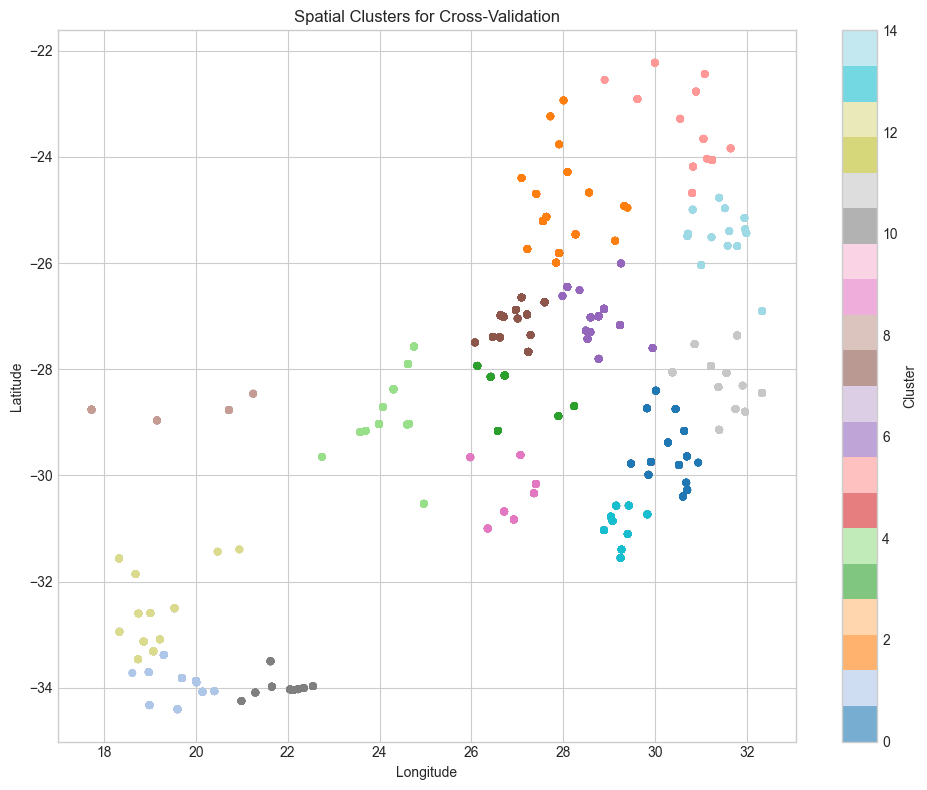

In [12]:
# Visualize clusters
fig, ax = plt.subplots(figsize=(10, 8))
scatter = ax.scatter(coords[:, 1], coords[:, 0], c=spatial_clusters, cmap='tab20', alpha=0.6, s=20)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.set_title('Spatial Clusters for Cross-Validation')
plt.colorbar(scatter, label='Cluster')
plt.tight_layout()
plt.savefig('spatial_clusters.png', dpi=150)
plt.show()

In [13]:
N_FOLDS = 5
gkf = GroupKFold(n_splits=N_FOLDS)


## Training tree-based models 

In [14]:
def evaluate_model(y_true, y_pred, target_name):
    """Calculate evaluation metrics"""
    r2 = r2_score(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    return {'target': target_name, 'R2': r2, 'RMSE': rmse, 'MAE': mae}

def train_and_evaluate(model_class, model_params, X, y, groups, target_name, apply_log=False):
    """Train model with spatial CV and return metrics + feature importance"""
    
    fold_metrics = []
    fold_importances = []
    oof_preds = np.zeros(len(X))
    
    y_transformed = np.log1p(y) if apply_log else y
    
    for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y_transformed, groups)):
        X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_tr, y_val = y_transformed.iloc[train_idx], y_transformed.iloc[val_idx]
        
        model = model_class(**model_params)
        
        # Handle different model types
        if 'catboost' in str(model_class).lower():
            model.fit(X_tr, y_tr, verbose=0)
        else:
            model.fit(X_tr, y_tr)
        
        preds = model.predict(X_val)
        oof_preds[val_idx] = preds
        
        # Inverse transform for metrics
        if apply_log:
            preds_orig = np.expm1(preds)
            y_val_orig = np.expm1(y_val)
        else:
            preds_orig = preds
            y_val_orig = y_val
        
        metrics = evaluate_model(y_val_orig, preds_orig, target_name)
        metrics['fold'] = fold + 1
        fold_metrics.append(metrics)
        
        # Feature importance
        fold_importances.append(model.feature_importances_)
    
    # Average importance across folds
    avg_importance = np.mean(fold_importances, axis=0)
    
    # OOF metrics
    if apply_log:
        oof_metrics = evaluate_model(y, np.expm1(oof_preds), target_name)
    else:
        oof_metrics = evaluate_model(y, oof_preds, target_name)
    
    return {
        'fold_metrics': pd.DataFrame(fold_metrics),
        'oof_metrics': oof_metrics,
        'importance': avg_importance,
        'oof_preds': np.expm1(oof_preds) if apply_log else oof_preds
    }


## Baseline: LightGBM model

In [15]:
print("="*70)
print("TRAINING LIGHTGBM MODELS")
print("="*70)

lgbm_params = {
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 6,
    'num_leaves': 31,
    'min_child_samples': 20,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': 42,
    'verbose': -1,
    'n_jobs': -1
}

lgbm_results = {}

for target in TARGETS:
    print(f"\n{'─'*50}")
    print(f"Target: {target}")
    print(f"{'─'*50}")
    
    y = y_train[target]
    
    # Apply log transform for DRP (heavily skewed)
    apply_log = 'Phosphorus' in target
    if apply_log:
        print("  → Applying log1p transform")
    
    results = train_and_evaluate(
        LGBMRegressor, 
        lgbm_params,
        X_train_filled, 
        y, 
        spatial_clusters,
        target,
        apply_log=apply_log
    )
    
    lgbm_results[target] = results
    
    # Print fold metrics
    print(f"\n  Fold Results:")
    print(results['fold_metrics'][['fold', 'R2', 'RMSE', 'MAE']].to_string(index=False))
    
    # Print OOF metrics
    print(f"\n  OOF R²: {results['oof_metrics']['R2']:.4f}")
    print(f"  OOF RMSE: {results['oof_metrics']['RMSE']:.2f}")

# Summary
print("\n" + "="*70)
print("LIGHTGBM CROSS-VALIDATION SUMMARY")
print("="*70)

summary_data = []
for target, results in lgbm_results.items():
    fold_df = results['fold_metrics']
    summary_data.append({
        'Target': target,
        'Mean R²': fold_df['R2'].mean(),
        'Std R²': fold_df['R2'].std(),
        'Mean RMSE': fold_df['RMSE'].mean(),
        'OOF R²': results['oof_metrics']['R2']
    })

summary_df = pd.DataFrame(summary_data)
print(summary_df.to_string(index=False))

mean_r2 = summary_df['OOF R²'].mean()
print(f"\n*** MEAN R² ACROSS ALL TARGETS: {mean_r2:.4f} ***")

TRAINING LIGHTGBM MODELS

──────────────────────────────────────────────────
Target: Total Alkalinity
──────────────────────────────────────────────────

  Fold Results:
 fold       R2      RMSE       MAE
    1 0.406845 53.701933 41.065036
    2 0.691230 43.612281 32.018452
    3 0.437570 42.547980 30.858787
    4 0.417051 37.453587 25.996768
    5 0.388046 60.236009 46.161162

  OOF R²: 0.5878
  OOF RMSE: 47.95

──────────────────────────────────────────────────
Target: Electrical Conductance
──────────────────────────────────────────────────

  Fold Results:
 fold        R2       RMSE        MAE
    1  0.491266 189.335085 141.425613
    2  0.210875 283.118383 181.952643
    3  0.410450 176.223265 124.114143
    4 -0.006507 241.843866 171.662938
    5  0.107098 401.792693 303.274904

  OOF R²: 0.3813
  OOF RMSE: 268.94

──────────────────────────────────────────────────
Target: Dissolved Reactive Phosphorus
──────────────────────────────────────────────────
  → Applying log1p transfor

### feature importance analysis 

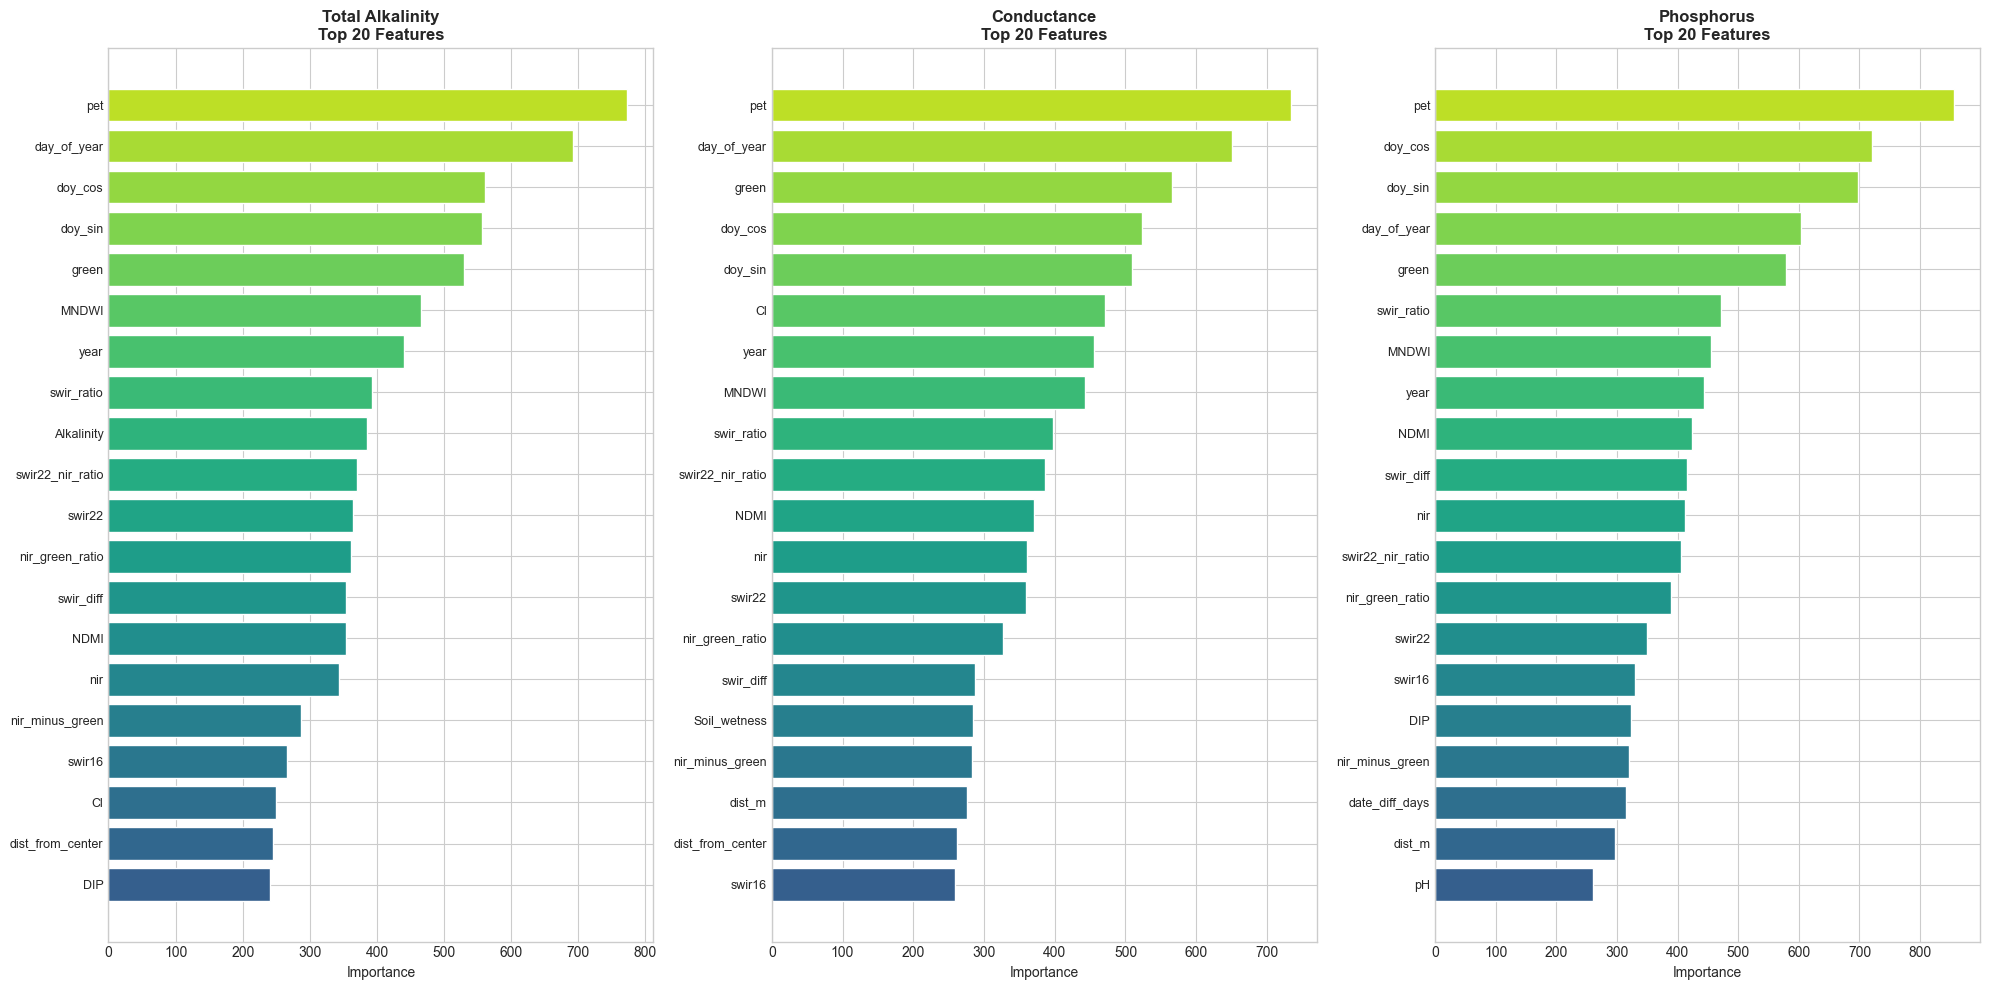

✓ Feature importance plot saved to feature_importance_lgbm.png


In [16]:
fig, axes = plt.subplots(1, 3, figsize=(20, 10))

for idx, target in enumerate(TARGETS):
    importance = lgbm_results[target]['importance']
    
    # Get top 20 features
    sorted_idx = np.argsort(importance)[-20:]
    
    ax = axes[idx]
    colors = plt.cm.viridis(np.linspace(0.3, 0.9, len(sorted_idx)))
    ax.barh(range(len(sorted_idx)), importance[sorted_idx], color=colors)
    ax.set_yticks(range(len(sorted_idx)))
    ax.set_yticklabels([feature_cols[i] for i in sorted_idx], fontsize=9)
    ax.set_xlabel('Importance', fontsize=10)
    
    # Shorten title
    short_name = target.replace('Dissolved Reactive ', '').replace('Electrical ', '')
    ax.set_title(f'{short_name}\nTop 20 Features', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.savefig('feature_importance_lgbm.png', dpi=150, bbox_inches='tight')
plt.show()

print("✓ Feature importance plot saved to feature_importance_lgbm.png")

In [17]:
importance_summary = pd.DataFrame({'feature': feature_cols})

for target in TARGETS:
    short_name = target.split()[0]  # First word
    importance_summary[f'{short_name}_imp'] = lgbm_results[target]['importance']

# Add rank columns
for target in TARGETS:
    short_name = target.split()[0]
    importance_summary[f'{short_name}_rank'] = importance_summary[f'{short_name}_imp'].rank(ascending=False).astype(int)

# Average importance
imp_cols = [c for c in importance_summary.columns if '_imp' in c]
importance_summary['avg_importance'] = importance_summary[imp_cols].mean(axis=1)
importance_summary['avg_rank'] = importance_summary['avg_importance'].rank(ascending=False).astype(int)

# Sort by average importance
importance_summary = importance_summary.sort_values('avg_importance', ascending=False)

print("\n--- TOP 25 MOST IMPORTANT FEATURES (averaged across targets) ---")
print(importance_summary[['feature', 'avg_importance', 'avg_rank']].head(25).to_string(index=False))

# Save full importance table
importance_summary.to_csv('feature_importance_summary.csv', index=False)
print("\n✓ Full importance table saved to feature_importance_summary.csv")


--- TOP 25 MOST IMPORTANT FEATURES (averaged across targets) ---
         feature  avg_importance  avg_rank
             pet      787.600000         1
     day_of_year      648.600000         2
         doy_cos      601.600000         3
         doy_sin      588.000000         4
           green      557.800000         5
           MNDWI      454.400000         6
            year      446.266667         7
      swir_ratio      420.400000         8
swir22_nir_ratio      387.600000         9
            NDMI      382.866667        10
             nir      372.133333        11
 nir_green_ratio      358.800000        12
          swir22      357.733333        13
       swir_diff      352.266667        14
              Cl      302.266667        15
 nir_minus_green      296.666667        16
          swir16      284.733333        17
          dist_m      265.400000        18
dist_from_center      247.333333        19
             DIP      245.533333        20
  date_diff_days      236.00000

## Comparison with other tree models 

In [18]:
print("\n" + "="*70)
print("COMPARING TREE-BASED MODELS")
print("="*70)

# Models to compare
models_to_compare = {
    'LightGBM': (LGBMRegressor, {
        'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 6, 'random_state': 42, 'verbose': -1
    }),
    'XGBoost': (XGBRegressor, {
        'n_estimators': 300, 'learning_rate': 0.05, 'max_depth': 6, 'random_state': 42, 'verbosity': 0
    }),
    'RandomForest': (RandomForestRegressor, {
        'n_estimators': 200, 'max_depth': 15, 'random_state': 42, 'n_jobs': -1
    }),
    'ExtraTrees': (ExtraTreesRegressor, {
        'n_estimators': 200, 'max_depth': 15, 'random_state': 42, 'n_jobs': -1
    }),
    'GradientBoosting': (GradientBoostingRegressor, {
        'n_estimators': 200, 'learning_rate': 0.05, 'max_depth': 6, 'random_state': 42
    })
}

comparison_results = []

for model_name, (model_class, params) in models_to_compare.items():
    print(f"\n--- {model_name} ---")
    
    for target in TARGETS:
        y = y_train[target]
        apply_log = 'Phosphorus' in target
        
        results = train_and_evaluate(
            model_class, params, X_train_filled, y, 
            spatial_clusters, target, apply_log=apply_log
        )
        
        comparison_results.append({
            'Model': model_name,
            'Target': target.split()[0],  # Shortened name
            'R2': results['oof_metrics']['R2'],
            'RMSE': results['oof_metrics']['RMSE']
        })
        
        print(f"  {target.split()[0]}: R² = {results['oof_metrics']['R2']:.4f}")

# Create comparison table
comparison_df = pd.DataFrame(comparison_results)
comparison_pivot = comparison_df.pivot(index='Model', columns='Target', values='R2')
comparison_pivot['Mean R²'] = comparison_pivot.mean(axis=1)
comparison_pivot = comparison_pivot.sort_values('Mean R²', ascending=False)

print("\n" + "="*70)
print("MODEL COMPARISON (OOF R² by Target)")
print("="*70)
print(comparison_pivot.round(4).to_string())


COMPARING TREE-BASED MODELS

--- LightGBM ---
  Total: R² = 0.5907


KeyboardInterrupt: 

In [ ]:
fig, ax = plt.subplots(figsize=(12, 6))
comparison_pivot.drop('Mean R²', axis=1).plot(kind='bar', ax=ax, width=0.8)
ax.set_ylabel('R² Score')
ax.set_title('Model Comparison: R² by Target (Spatial CV)')
ax.set_xticklabels(comparison_pivot.index, rotation=45, ha='right')
ax.legend(title='Target', bbox_to_anchor=(1.02, 1), loc='upper left')
ax.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# training final prediction 

In [19]:
print("\n" + "="*70)
print("TRAINING FINAL MODELS ON ALL DATA")
print("="*70)

# Use LightGBM (or best model from comparison)
final_models = {}
final_predictions = {}

for target in TARGETS:
    print(f"\nTraining final model for: {target}")
    
    y = y_train[target]
    apply_log = 'Phosphorus' in target
    
    if apply_log:
        y_transformed = np.log1p(y)
    else:
        y_transformed = y
    
    # Train on full data with LightGBM
    model = XGBRegressor(
        n_estimators=600,          # More iterations for final
        learning_rate=0.05,
        max_depth=6,
        random_state=42,
        verbosity=0,
        n_jobs=-1
    )
    model.fit(X_train_filled, y_transformed)
    
    # Predict on submission set
    preds = model.predict(X_submit_filled)
    
    if apply_log:
        preds = np.expm1(preds)
    
    # Clip to reasonable range (based on training data)
    train_min = y.min()
    train_max = y.max()
    preds = np.clip(preds, train_min * 0.5, train_max * 1.5)
    
    final_models[target] = model
    final_predictions[target] = preds
    
    print(f"  Predictions - Min: {preds.min():.2f}, Max: {preds.max():.2f}, Mean: {preds.mean():.2f}")


TRAINING FINAL MODELS ON ALL DATA

Training final model for: Total Alkalinity
  Predictions - Min: 9.02, Max: 321.24, Mean: 119.32

Training final model for: Electrical Conductance
  Predictions - Min: 79.11, Max: 1109.49, Mean: 477.05

Training final model for: Dissolved Reactive Phosphorus
  Predictions - Min: 8.33, Max: 111.41, Mean: 27.16


## create submission file 

In [20]:
# Create submission dataframe
submission = pd.DataFrame({
    'Latitude': submit_processed['Latitude'],
    'Longitude': submit_processed['Longitude'],
    'Sample Date': submit_processed['Sample Date'].dt.strftime('%Y-%m-%d') if hasattr(submit_processed['Sample Date'], 'dt') else submit_processed['Sample Date'],
    'Total Alkalinity': final_predictions['Total Alkalinity'],
    'Electrical Conductance': final_predictions['Electrical Conductance'],
    'Dissolved Reactive Phosphorus': final_predictions['Dissolved Reactive Phosphorus']
})

In [ ]:
!pip install iPython

In [ ]:
from IPython.display import FileLink 

# FileLink(r'data/submission_predictions.csv')

In [25]:
# FileLink('data/submission_predictions.csv')
cols = list(submission.columns)
i, j = cols.index('Latitude'), cols.index('Longitude')
cols[i], cols[j] = cols[j], cols[i]
submission = submission[cols]

In [26]:
# Save
submission.to_csv('data/submission_predictions.csv', index=False)
# FileLink(r'data/submission_predictions.csv')
print("\n✓ Submission saved to submission_predictions.csv")
print(f"\nSubmission shape: {submission.shape}")
print("\nSubmission preview:")
print(submission.head(10))


✓ Submission saved to submission_predictions.csv

Submission shape: (200, 6)

Submission preview:
   Longitude  Latitude Sample Date  Total Alkalinity  Electrical Conductance  \
0   28.01556 -32.51528  2011-01-19        103.837234              330.624207   
1   27.36667 -32.57917  2011-03-09         37.304161              181.371353   
2   27.36667 -32.57917  2011-02-07         32.812584               79.111847   
3   24.43917 -34.09639  2011-03-09         28.204157              229.702484   
4   28.01556 -32.51528  2011-06-06        112.739555              433.269226   
5   24.23556 -33.20278  2011-05-30        205.092010              930.251221   
6   27.82278 -32.04333  2011-05-09         78.281891              241.061447   
7   26.07750 -33.32917  2011-05-06        180.769043              813.991699   
8   27.82278 -32.04333  2011-04-11         75.005699              238.983795   
9   24.43917 -34.09639  2011-10-12         27.235294              285.946747   

   Dissolved Reactiv

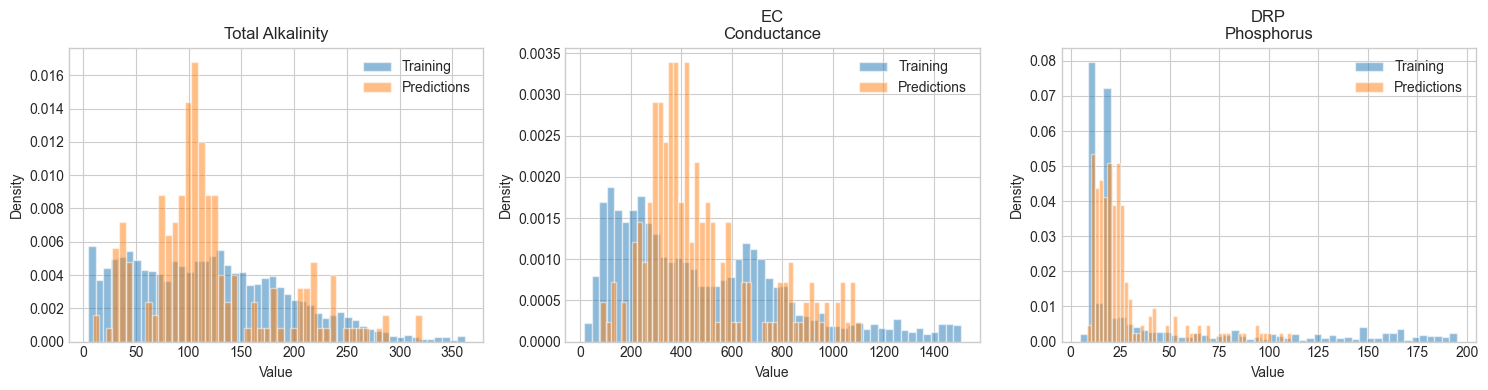

✓ Distribution comparison saved to prediction_distributions.png


In [22]:
# Compare prediction distributions to training
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, target in enumerate(TARGETS):
    ax = axes[idx]
    
    # Training distribution
    ax.hist(y_train[target], bins=50, alpha=0.5, label='Training', density=True)
    # Prediction distribution
    ax.hist(final_predictions[target], bins=50, alpha=0.5, label='Predictions', density=True)
    
    short_name = target.replace('Dissolved Reactive ', 'DRP\n').replace('Electrical ', 'EC\n')
    ax.set_title(short_name)
    ax.legend()
    ax.set_xlabel('Value')
    ax.set_ylabel('Density')

plt.tight_layout()
plt.savefig('prediction_distributions.png', dpi=150)
plt.show()

print("✓ Distribution comparison saved to prediction_distributions.png")